In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from common import Images, Fonts, Colors, add_twitter_handle
from matplotlib.patches import Rectangle, Ellipse, Arc
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [2]:
field = Colors.WHITE
lines = Colors.BLACK

def move_point_towards(x, y, x2, y2, r):
    """Moves x,y towards x2, y2 with a distance of r."""
    d = math.sqrt((x - x2) ** 2 + (y - y2) ** 2)
    theta = math.atan(-(y2 - y) / (x2 - x + 0.0001))
    x_sign = 1 if x < x2 else -1
    y_sign = 1 if (y < y2 and x > x2) or (y > y2 and x > x2) else -1
    
    return (x + x_sign * math.cos(theta) * r, y + y_sign * math.sin(theta) * r)


def player_mark(ax, x, y, label):
    ax.plot(
        x,
        y,
        marker="o",
        markerfacecolor=field,
        markeredgecolor=lines,
        markersize=20,
        markeredgewidth=3,
    )
    ax.text(
        x,
        y,
        label,
        ha="center",
        va="center",
        color=lines,
        fontsize=14,
    )
    
def arrow_path(ax, start, end, style):
    ax.add_patch(
        patches.FancyArrowPatch(
            start,
            end,
            arrowstyle="-",
            mutation_scale=40,
            linewidth=3,
            linestyle=style,
            color=lines,
        )
    )
    ax.add_patch(
        patches.FancyArrowPatch(
            move_point_towards(end[0], end[1], start[0], start[1], 0.5),
            move_point_towards(end[0], end[1], start[0], start[1], -1.25),
            arrowstyle="->",
            mutation_scale=40,
            linewidth=3,
            linestyle="-",
            color=lines,
        )
    )

In [3]:
def plot_buildup(file, title, subtitle):
    df = pd.read_csv("data/" + file + ".csv")

    # Normalize coordinates to a 100x70 field
    df["y"] = df["y"] * 70 / 100
    df["y2"] = df["y2"] * 70 / 100


    # Setup
    plt.rcParams["figure.figsize"] = (14, 9)
    plt.figure(dpi=200)
    fig, ax = plt.subplots()
    fig.patch.set_facecolor(Colors.WHITE)
    ax.set_facecolor(Colors.WHITE)
    plt.xkcd()

    # Build the field
    # Goal
    ax.plot([100, 100 + 1, 100 + 1, 100], [31, 31, 31 + 8, 31 + 8], color=lines, lw=3)
    ax.plot([0, 0 - 1, 0 - 1, 0], [31, 31, 31 + 8, 31 + 8], color=lines, lw=3)
    # Touchline
    ax.plot([0, 100, 100, 0, 0], [0, 0, 70, 70, 0], color=lines, lw=5)
    # Center circle
    ax.add_patch(Ellipse((50, 35), 18, 20, ec=lines, fill=False, lw=5))
    # Center line
    ax.add_patch(Rectangle((50, 0), 50, 70, ec=lines, fill=False, lw=5))
    # 18-yard box
    ax.plot([100, 100 - 18, 100 - 18, 100], [14, 14, 14 + 42, 14 + 42], color=lines, lw=5)
    ax.plot([0, 18, 18, 0], [14, 14, 14 + 42, 14 + 42], color=lines, lw=5)
    # 6-yard box
    ax.plot(
        [100, 100 - 6, 100 - 6, 100],
        [25, 25, 25 + 20, 25 + 20],
        color=lines,
        lw=5,
    )
    ax.plot([0, 6, 6, 0], [25, 25, 25 + 20, 25 + 20], color=lines, lw=5)

    x_prev = None
    y_prev = None
    x2_prev = None
    y2_prev = None
    for i, row in df.iterrows():
        player_mark(ax, row["x"], row["y"], row["number"])

        # When there is a longer distance between the previous pass and the next,
        # this means the player was dribbling
        if x_prev and y_prev:
            if math.sqrt((x2_prev - row["x"]) ** 2 + (y2_prev - row["y"]) ** 2) > 5:
                # When a dribble is involved, use the original pass end from the
                # previous event, and add a dribble event
                start = move_point_towards(x_prev, y_prev, x2_prev, y2_prev, 2)
                end = move_point_towards(x2_prev, y2_prev, x_prev, y_prev, 2.5)
                arrow_path(ax, start, end, "--")

                player_mark(ax, x2_prev, y2_prev, row["number"])
                arrow_path(
                    ax,
                    move_point_towards(x2_prev, y2_prev, row["x"], row["y"], 2),
                    move_point_towards(row["x"], row["y"], x2_prev, y2_prev, 2.5),
                    "-",
                )
            else:
                # Otherwise use the next players current location as the pass end
                start = move_point_towards(x_prev, y_prev, row["x"], row["y"], 2)
                end = move_point_towards(row["x"], row["y"], x_prev, y_prev, 2.5)
                arrow_path(ax, start, end, "--")


        x_prev = row["x"]
        y_prev = row["y"]
        x2_prev = row["x2"]
        y2_prev = row["y2"]

    # Goal
    arrow_path(ax, (x_prev, y_prev), (x2_prev, y2_prev), "--")

    # Axes
    plt.ylim([-2, 72])
    plt.xlim([-2, 102])
    ax.axis("off")

    # Title
    plt.title(
        title,
        fontproperties=Fonts.BARLOW_BOLD,
        size=32,
        x=0.03,
        y=1.08,
        ha="left",
        color=Colors.BLACK,
    )

    # Subtitle
    ax.text(
        0.03,
        1.03,
        subtitle,
        fontproperties=Fonts.BARLOW,
        size=18,
        ha="left",
        transform=ax.transAxes,
    )

    add_twitter_handle(fig, x=0.78, y=0.08, fs=16, w=0.028)

    # Save image
    plt.savefig("images/" + file + ".png", bbox_inches="tight", pad_inches=0.5, dpi=200)

<Figure size 2800x1800 with 0 Axes>

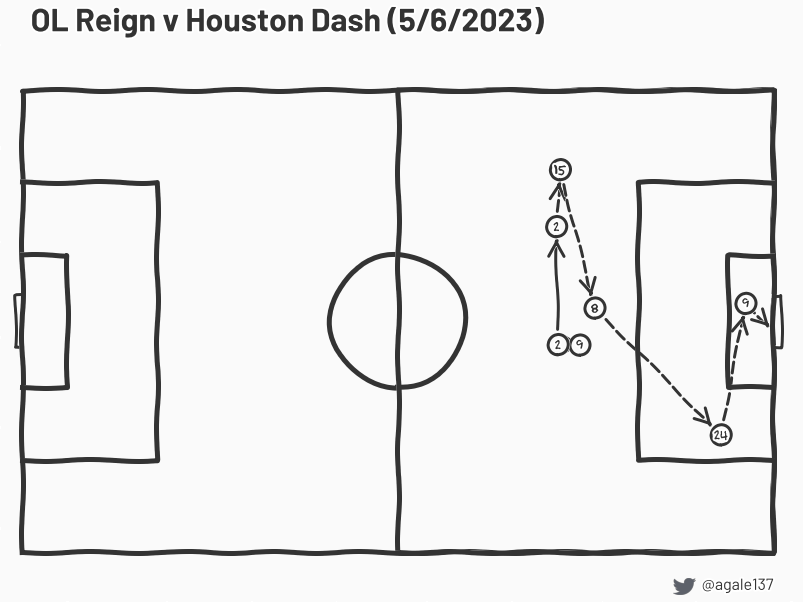

In [8]:
plot_buildup(
    "5-6-RGN-goal2",
    "OL Reign v Houston Dash (5/6/2023)",
    "",
)